# Wikipedia ClickStream data
"how people get to a Wikipedia article and what links they click on"


Data from: https://meta.wikimedia.org/wiki/Research:Wikipedia_clickstream



## Importing data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


# Before opening the csv, we can use 'chardet' library to check the encoding of our file
import chardet
with open("data/2017clickstream_cleaned.csv", 'rb') as rawdata:
    encoding = chardet.detect(rawdata.read(10000))

# check encoding
print(encoding)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [57]:
# Read CSV file to dataframe
data=pd.read_csv("data/2017_01_en_clickstream.csv", lineterminator='\n', sep=",", header=0)
print(data.tail())

                        prev                           curr      type   n
1048570       other-internal  The_Deadly_Mantis_(1978_film)  external  17
1048571           Gordon_Liu  The_Deadly_Mantis_(1978_film)      link  44
1048572  2002_UEFA_Cup_Final                  Ferry_de_Haan      link  16
1048573         other-search                  Ferry_de_Haan  external  22
1048574          other-empty                  Ferry_de_Haan  external  30


Legend:

* n = number of occurrances of "prev" - "curr" pair

* prev = referer (page, where from client came to "curr")
  
>    the article title =  an article in the main namespace 

>    other-internal = a page from any other Wikimedia project

>    other-search = an external search engine

>    other-external = any other external site

>    other-empty = an empty referer

>    other-other = anything else

* curr = the article requested by client
 

* type:

> link: if the referer and request are both articles and the referer links to the request

> external: if the referer host is not wikipedia.org

> other: if the referer and request are both articles but the referer does not link to the request. This can happen when clients search or spoof their refer.


## Data Cleaning

In [5]:
# Check for null:
print("Null values in columns: \n",data.isnull().sum(),"\n")


# There is one null in 'prev', find the row:
print("The null value row: \n", data[data['prev'].isnull()].index)

# Drop NaN row
data.dropna(inplace=True)

Null values in columns: 
 prev    0
curr    0
type    0
n       0
dtype: int64 

The null value row: 
 Int64Index([], dtype='int64')


    
    
While working further on, a problem emerges. Some rows seem to contain too much data. Let's list rows, that contain suspiciously long strings. 

First, create a "mask". The *longmask* list gets "true" if the value in 'curr' column is more than 200 characters, otherwise false:

In [9]:
longmask = (data['curr'].str.len() > 200)
# Using the mask, create dataframe, which contains the rows with "true" values:
longstrings = data.loc[longmask]

# Show the dataframe of long strings
longstrings

,prev,curr,type,n
554818,Even_Worse,"Weird_Al""_Yankovic_(album)\tlink\t21\nother-in...",external,104
610788,David_Bowie_(1969_album),"Heroes""_(David_Bowie_album)\tlink\t16\nHunky_D...",external,154
836505,other-internal,"I_AM""_Activity\texternal\t80\nSt._Germain_(The...",link,62
848523,other-search,"Weird_Al""_Yankovic:_The_Ultimate_Collection\te...",external,20


> ALTERNATIVE

> We could do this in a loop as well, but it's a lot slower.

>def longrows():

>    count = 0


>    for i in range(len(data)-1):

>        if (len(str(data2['curr'][i])) > 200 ) :

>            print(str(data2['curr'][i]), "row number: ", i)

>            count+=1

>    print("counted:", count)

### Fixing the CSV file

The rows with long strings, seem to lack a quotation mark(") from the beginning.
We could just remove all quotes, but that would lead to further problems, because some values have a comma
inside the string, like "cyrene, Libya". Removing quotes would make it into two strings.


So, let's read the file again, line by line, and try to fix it:

In [14]:
with open("data/2017_01_en_clickstream.csv", encoding="utf-8") as f: # utf-8 needed under Windows
    lines = f.readlines()

# The first faulty line is not 554818, but 554818+1 = 554819. Because when reading line by line,
# the title row is the first line.
print("The first faulty line (554818): ",lines[554818+1])



# this error came under Windows:
# UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 2372: character maps to <undefined>
# FIX: -> encoding=utf-8

The first faulty line (554818):  Even_Worse,"Weird_Al""_Yankovic_(album)	link	21



Let's try to find the rows we found out to be too long in the dataframe, and add the missing quotation mark to them.

The *correct_rows* -function:

> 1. Iterate through the *lines* -list (the csv file)
> 2. If *prev* string from *longstrings* is in the current "row"
> 3. --- if the beginning letters of *curr* string is found too
> 4. --- --- if the row contains a quotation mark
> 5. --- --- ---  double the first quotation mark from the left.
> 6. Search again with the next string in *longstrings*


Finally save the corrected csv file.

In [16]:
def correct_rows():
    rownumber = 0
    sstring1 = str(data.loc[longstrings.index]['prev'].values[rownumber])
    sstring2 = str(data.loc[longstrings.index]['curr'].values[rownumber][:4])
    print("searching: ", sstring1, sstring2, end="\t")
    
    for i in range(len(lines)):    
        if ((sstring1) in lines[i]):
            if ((sstring2) in lines[i]):
                if (('"') in lines[i]):
                    print(" * ")
                    lines[i] = lines[i].replace('"','""',1)
                    rownumber+=1
                    if (rownumber > len(longstrings)-1) : return
                    sstring1 = str(data.loc[longstrings.index]['prev'].values[rownumber])
                    sstring2 = str(data.loc[longstrings.index]['curr'].values[rownumber][:4])
                    print("searching: ", sstring1, sstring2, end="\t")
    
    
correct_rows()

    
# Check that it worked
print("\nnew: ", lines[554818+1])

# Now, save the file
file = open('data/2017clickstream_cleaned.csv','w', encoding='utf-8', errors='strict') # utf-8 needed under Windows
file.writelines(lines)
file.close()

print("file saved")

searching:  Even_Worse Weir	 * 
searching:  David_Bowie_(1969_album) Hero	 * 
searching:  other-internal I_AM	 * 
searching:  other-search Weir	 * 

new:  Even_Worse,""Weird_Al""_Yankovic_(album)	link	21

file saved


In [25]:
# Let's read the data again from the cleansed file
data=pd.read_csv("data/2017clickstream_cleaned.csv", sep=",", header=0, encoding='utf-8')
data.head()

# List top 10 articles
tops = data.groupby('curr').sum().sort_values(['n'], ascending=False).head(15)
print("Top 10 most read articles \n", tops)

Top 10 most read articles 
                                     n
curr                                 
Donald_Trump                9858346.0
XXX                         1942063.0
United_States               1540836.0
Jared_Kushner               1283512.0
Gavin_Rossdale              1205584.0
Unbreakable_(film)          1100870.0
Ed_Roberts_(activist)       1030458.0
Ben_Affleck                  939473.0
Jacqueline_Kennedy_Onassis   926204.0
Tom_Cruise                   743553.0
Hillary_Clinton              652527.0
Lionel_Messi                 636973.0
Andrew_Garfield              627049.0
Jackie_Chan                  625123.0
George_Washington            622800.0


### Visualise top 10 articles with Matplotlib bar chart

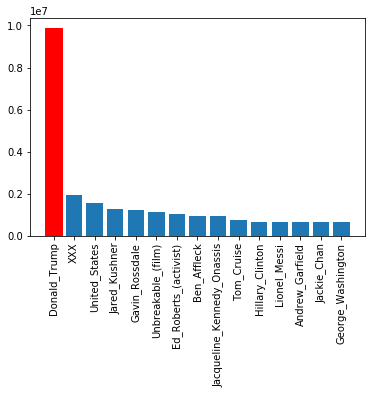

In [20]:
top = plt.bar(range(len(tops)), tops['n'])
top[0].set_color('r')

plt.xticks(range(len(tops)),tops.index, rotation=90) # Set labels and rotate 90 degrees
plt.show()

### Pie chart of where people came to the top 1 article

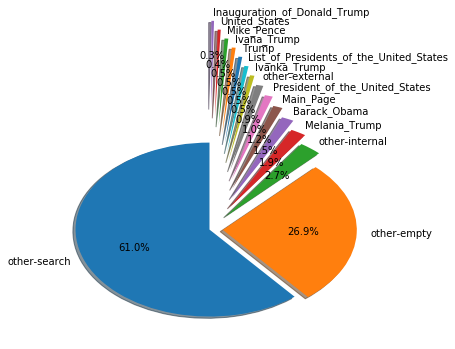

In [36]:
# Get the rows that have "Donald Trump" as the current article, group them by the 'prev' string, count them and sort.
refs = data.loc[data['curr'] == "Donald_Trump"].groupby('prev').sum().sort_values('n', ascending=False).head(15)

# Explode = how much is the slice apart from the pie
explode = np.arange(len(refs))*0.1

# Get 'n' column from the previously made 'refs' dataframe and get labels from 'refs' index,
# autopct = place percents (and format).
plt.pie(refs['n'], explode=explode, labels=refs.index, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.show()

### Visualising with NetworkX
"NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks."


https://networkx.github.io/documentation/stable/index.html

https://networkx.github.io/documentation/latest/_downloads/networkx_reference.pdf


---

Let's visualise the articles related to the number one article of Wikipedia with networkx MultiDiGraph,
which shows the direction of clicks from an article to another.

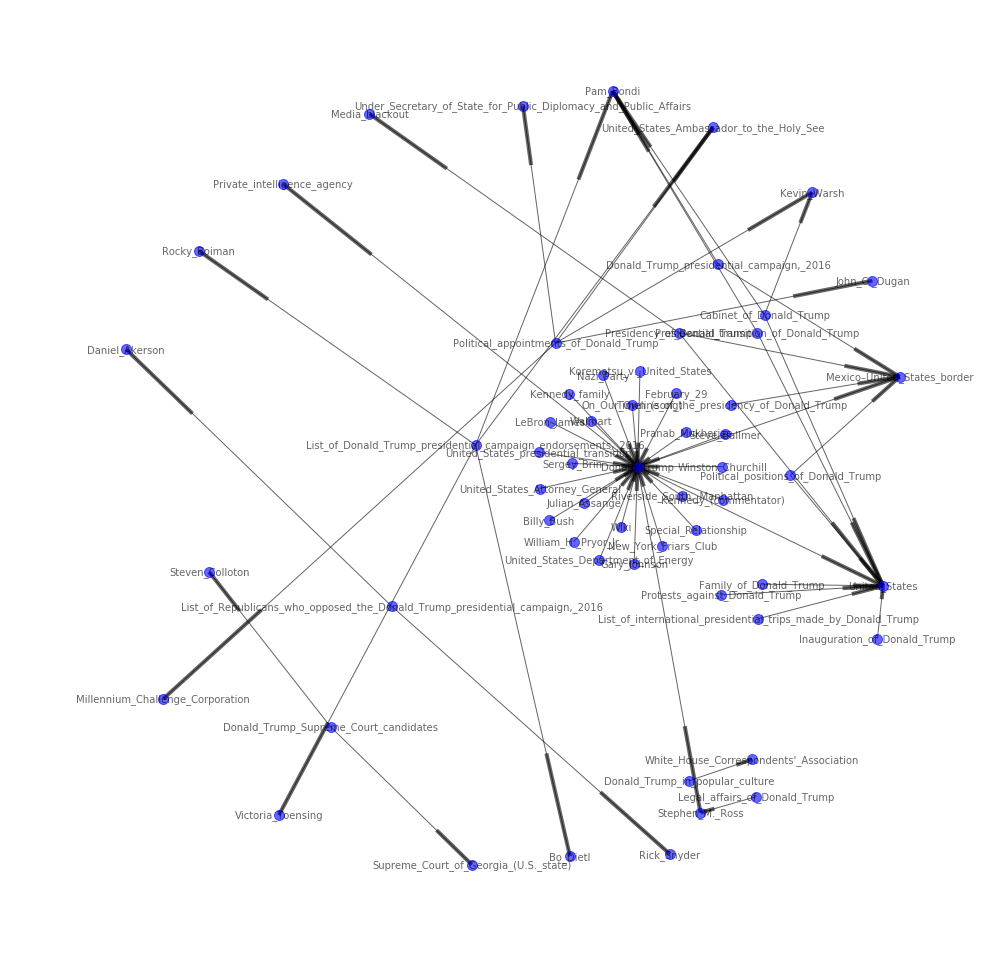

In [56]:
import networkx as nx

# The string to look for from the data
word="Donald_Trump"

# Let's select a piece of data from 'data', that contains the search string
data2 = data[data.prev.str.contains(word) | data.curr.str.contains(word)][270:330]
data2.reset_index(inplace=True, drop=True)

# Create a new networkx graph. MultiDiGraph = Directed graph with self loops and parallel edges
clickstream = nx.MultiDiGraph()

# Iterate through the dataframe and add the articles as edges
for i in range(len(data2)):
    clickstream.add_edge(data2['prev'][i], data2['curr'][i], traffic = data2['n'], size=100, weight=0.1)


# Draw the networkx graph   
fig = plt.figure(figsize=(13,13))

options = {
    'node_color': 'blue',
    'node_size': 100,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 2,
    'with_labels':'True',
    'node_shape': 'o',
    'alpha': 0.6, 
    'style' :'solid', 
    'font_size':10,
    'edge_cmap':'plt.cm.Blues',}

nx.draw(clickstream, arrows=True, **options)
plt.show()

#https://networkx.github.io/documentation/stable/reference/generators.html#module-networkx.generators.small